In [1]:
# extract_accel_data.py
from datetime import datetime
import csv

filename = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025.log"

timestamps, t_values, x_values, y_values, z_values = [], [], [], [], []

with open(filename, 'r') as file:
    for line in file:
        if all(k in line for k in ['t:', 'x:', 'y:', 'z:']):
            # Extract timestamp
            if '[' in line and ']' in line:
                timestamps.append(line.split('[')[1].split(']')[0])
            
            # Extract sensor values
            parts = line.split()
            t=x=y=z=None
            for p in parts:
                if p.startswith('t:'): t=int(p[2:])
                elif p.startswith('x:'): x=int(p[2:])
                elif p.startswith('y:'): y=int(p[2:])
                elif p.startswith('z:'): z=int(p[2:])
            if None not in (t,x,y,z):
                t_values.append(t)
                x_values.append(x)
                y_values.append(y)
                z_values.append(z)

# Save CSV
csv_file = filename.replace('.log','_accelerometer.csv')
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['timestamp','t','x','y','z'])
    writer.writerows(zip(timestamps,t_values,x_values,y_values,z_values))

print(f"Data saved to {csv_file}")


Data saved to C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_accelerometer.csv


<h1>Process Accelerometer Signals

In [2]:
import math
import csv
from collections import deque
from datetime import datetime
import numpy as np
from scipy.signal import savgol_filter, find_peaks

filename = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025.log"   

def moving_average(data, window_size):
    """Calcola media mobile con finestra specificata"""
    if len(data) < window_size:
        return [sum(data) / len(data)] * len(data)
    
    result = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        result.append(sum(data[start:end]) / (end - start))
    return result

def calculate_pitch_roll(x, y, z):
    """Calcola pitch e roll dall'accelerometro"""
    # Pitch: rotazione attorno asse X
    pitch = math.atan2(y, math.sqrt(x*x + z*z)) * 180 / math.pi
    
    # Roll: rotazione attorno asse Y  
    roll = math.atan2(-x, math.sqrt(y*y + z*z)) * 180 / math.pi
    
    return pitch, roll

def detect_peaks_simple(signal, prominence=0.1):
    """Peak detection semplificato"""
    peaks = []
    for i in range(1, len(signal) - 1):
        if (signal[i] > signal[i-1] and 
            signal[i] > signal[i+1] and 
            signal[i] > prominence):
            peaks.append(i)
    return peaks

# Estrai dati base
raw_data = []
timestamps = []

with open(filename, 'r') as file:
    for line in file:
        if 't:' in line and 'x:' in line:
            # Estrai timestamp
            if '[' in line and ']' in line:
                timestamp_str = line.split('[')[1].split(']')[0]
                timestamps.append(timestamp_str)
            
            # Estrai valori accelerometro
            line_parts = line.split()
            t = x = y = z = None
            
            for part in line_parts:
                if part.startswith('t:'):
                    t = int(part[2:])
                elif part.startswith('x:'):
                    x = int(part[2:])
                elif part.startswith('y:'):
                    y = int(part[2:])
                elif part.startswith('z:'):
                    z = int(part[2:])
            
            if all(v is not None for v in [t, x, y, z]):
                raw_data.append([t, x, y, z])

if not raw_data:
    print("Nessun dato trovato!")
    exit()

print(f"Estratti {len(raw_data)} campioni")

# Separa i dati per i calcoli
t_values = [row[0] for row in raw_data]
x_values = [row[1] for row in raw_data]
y_values = [row[2] for row in raw_data]
z_values = [row[3] for row in raw_data]

# Calcola norm per ogni campione
norm_values = []
for x, y, z in zip(x_values, y_values, z_values):
    norm = math.sqrt(x*x + y*y + z*z)
    norm_values.append(norm)

# Calcola tempo in ms e secondi (stimato)
if len(timestamps) > 0:
    # Usa timestamp reali se disponibili
    start_time = datetime.strptime(timestamps[0], '%Y-%m-%d %H:%M:%S.%f')
    time_ms = []
    time_s = []
    
    for timestamp_str in timestamps:
        current_time = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')
        elapsed_ms = (current_time - start_time).total_seconds() * 1000
        time_ms.append(elapsed_ms)
        time_s.append(elapsed_ms / 1000)
else:
    # Stima tempo assumendo sampling rate costante
    time_ms = [i * 10 for i in range(len(raw_data))]  # 100Hz stimato
    time_s = [ms / 1000 for ms in time_ms]

# Calcola medie mobili (finestra 30 punti)
window_size = 30
x_mavg = moving_average(x_values, window_size)
y_mavg = moving_average(y_values, window_size)
z_mavg = moving_average(z_values, window_size)
norm_mavg = moving_average(norm_values, window_size)

# Calcola pitch e roll
pitch_values = []
roll_values = []
for x, y, z in zip(x_values, y_values, z_values):
    pitch, roll = calculate_pitch_roll(x, y, z)
    pitch_values.append(pitch)
    roll_values.append(roll)

# Savitzky-Golay filter (se hai abbastanza dati)
if len(x_values) >= 5:
    try:
        x_sg = savgol_filter(x_values, window_length=5, polyorder=2)
    except:
        x_sg = x_values  # Fallback se errore
else:
    x_sg = x_values

# Peak detection sulla norm
try:
    peak_indices = detect_peaks_simple(norm_values, prominence=np.std(norm_values) * 0.5)
    is_peak = [False] * len(norm_values)
    for idx in peak_indices:
        is_peak[idx] = True
except:
    is_peak = [False] * len(norm_values)

# Risultati finali
print("\nPrimi 10 campioni con tutti i parametri:")
print("t\tx\ty\tz\ttime_ms\tnorm\tx_mavg\ty_mavg\tz_mavg\tnorm_mavg\tpitch\troll\tx_sg\ttime_s\tis_peak")

for i in range(min(10, len(raw_data))):
    print(f"{t_values[i]:.1f}\t{x_values[i]:.1f}\t{y_values[i]:.1f}\t{z_values[i]:.1f}\t"
          f"{time_ms[i]:.1f}\t{norm_values[i]:.2f}\t{x_mavg[i]:.1f}\t{y_mavg[i]:.1f}\t"
          f"{z_mavg[i]:.1f}\t{norm_mavg[i]:.2f}\t{pitch_values[i]:.1f}\t{roll_values[i]:.1f}\t"
        
          f"{x_sg[i]:.2f}\t{time_s[i]:.3f}\t{is_peak[i]}")
    
csv_data = []
for i in range(len(raw_data)):
    row = {
        'timestamp': timestamps[i] if i < len(timestamps) else "",
        't': t_values[i],
        'x': x_values[i],
        'y': y_values[i],
        'z': z_values[i],
        'time_ms': time_ms[i],
        'time_s': time_s[i],
        'norm': norm_values[i],
        'x_mavg': x_mavg[i],
        'y_mavg': y_mavg[i],
        'z_mavg': z_mavg[i],
        'norm_mavg': norm_mavg[i],
        'pitch': pitch_values[i],
        'roll': roll_values[i],
        'x_sg': x_sg[i] if i < len(x_sg) else x_values[i],
        'is_peak': int(is_peak[i])
    }
    csv_data.append(row)

# Scrivi il file CSV
csv_filename = filename.replace('.log', '_processed.csv')
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['timestamp', 't', 'x', 'y', 'z', 'time_ms', 'time_s', 'norm', 
                  'x_mavg', 'y_mavg', 'z_mavg', 'norm_mavg', 
                  'pitch', 'roll', 'x_sg', 'is_peak']
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(csv_data)

print(f"\nDati salvati in: {csv_filename}")
print(f"Totale righe salvate: {len(csv_data)}")

# Statistiche
print(f"\nDurata totale: {time_s[-1]:.3f} secondi")
print(f"Sampling rate medio: {len(raw_data) / time_s[-1]:.1f} Hz")
print(f"Picchi rilevati: {sum(is_peak)}")
print(f"Norm media: {sum(norm_values) / len(norm_values):.2f}")

Estratti 120066 campioni

Primi 10 campioni con tutti i parametri:
t	x	y	z	time_ms	norm	x_mavg	y_mavg	z_mavg	norm_mavg	pitch	roll	x_sg	time_s	is_peak
32123.0	-22.0	-229.0	55.0	0.0	236.54	-10.6	-236.1	45.0	241.70	-75.5	5.3	-23.26	0.000	False
7.0	-22.0	-214.0	59.0	4.0	223.07	-9.8	-239.5	43.9	244.79	-73.6	5.7	-19.37	0.004	False
6.0	-18.0	-221.0	62.0	13.0	230.24	-9.2	-240.9	43.0	246.04	-73.7	4.5	-18.34	0.013	False
7.0	-18.0	-236.0	52.0	21.0	242.33	-7.9	-239.5	44.2	244.91	-76.9	4.3	-20.40	0.021	False
9.0	-26.0	-266.0	24.0	29.0	268.34	-7.5	-242.2	45.1	247.63	-82.4	5.6	-21.89	0.029	False
7.0	-18.0	-278.0	0.0	33.0	278.58	-6.7	-245.0	44.9	250.27	-86.3	3.7	-21.00	0.033	True
8.0	-18.0	-259.0	20.0	48.0	260.39	-6.4	-246.8	45.4	252.09	-84.1	4.0	-15.94	0.048	False
7.0	-15.0	-251.0	41.0	55.0	254.77	-5.3	-247.0	46.4	252.47	-80.1	3.4	-18.17	0.055	False
11.0	-22.0	-236.0	34.0	61.0	239.45	-4.5	-247.5	47.3	253.14	-80.3	5.3	-18.83	0.061	False
7.0	-15.0	-229.0	52.0	74.0	235.31	-3.8	-248.1	47.5	253.75	-76.7	3

<h1>Detect Pauses / Rumination Events

=== RIFERIMENTI DAL VIDEO (convertiti in tempi accelerometro) ===
Ruminazione 1: 374.8s - 424.8s (durata: 50.0s)
Ruminazione 2: 428.8s - 489.8s (durata: 61.0s)
Ruminazione 3: 493.8s - 532.8s (durata: 39.0s)
Ruminazione 4: 539.8s - 602.8s (durata: 63.0s)
Ruminazione 5: 607.8s - 669.8s (durata: 62.0s)
Ruminazione 6: 674.8s - 734.8s (durata: 60.0s)
Ruminazione 7: 738.8s - 794.8s (durata: 56.0s)
Ruminazione 8: 802.8s - 860.8s (durata: 58.0s)
Ruminazione 9: 866.8s - 923.8s (durata: 57.0s)
Ruminazione 10: 927.8s - 930.8s (durata: 3.0s)

=== RISULTATI ACCELEROMETRO ===
Pause automatiche trovate (11):
  1. 335.2s - 349.9s (durata: 14.7s)
  2. 370.1s - 374.7s (durata: 4.7s)
  3. 424.5s - 428.9s (durata: 4.4s)
  4. 488.2s - 492.1s (durata: 3.9s)
  5. 533.7s - 539.1s (durata: 5.5s)
  6. 604.0s - 608.3s (durata: 4.2s)
  7. 671.8s - 675.3s (durata: 3.5s)
  8. 736.0s - 739.1s (durata: 3.1s)
  9. 801.4s - 803.7s (durata: 2.3s)
  10. 862.0s - 867.5s (durata: 5.5s)
  11. 925.3s - 928.8s (durata: 3.4s)


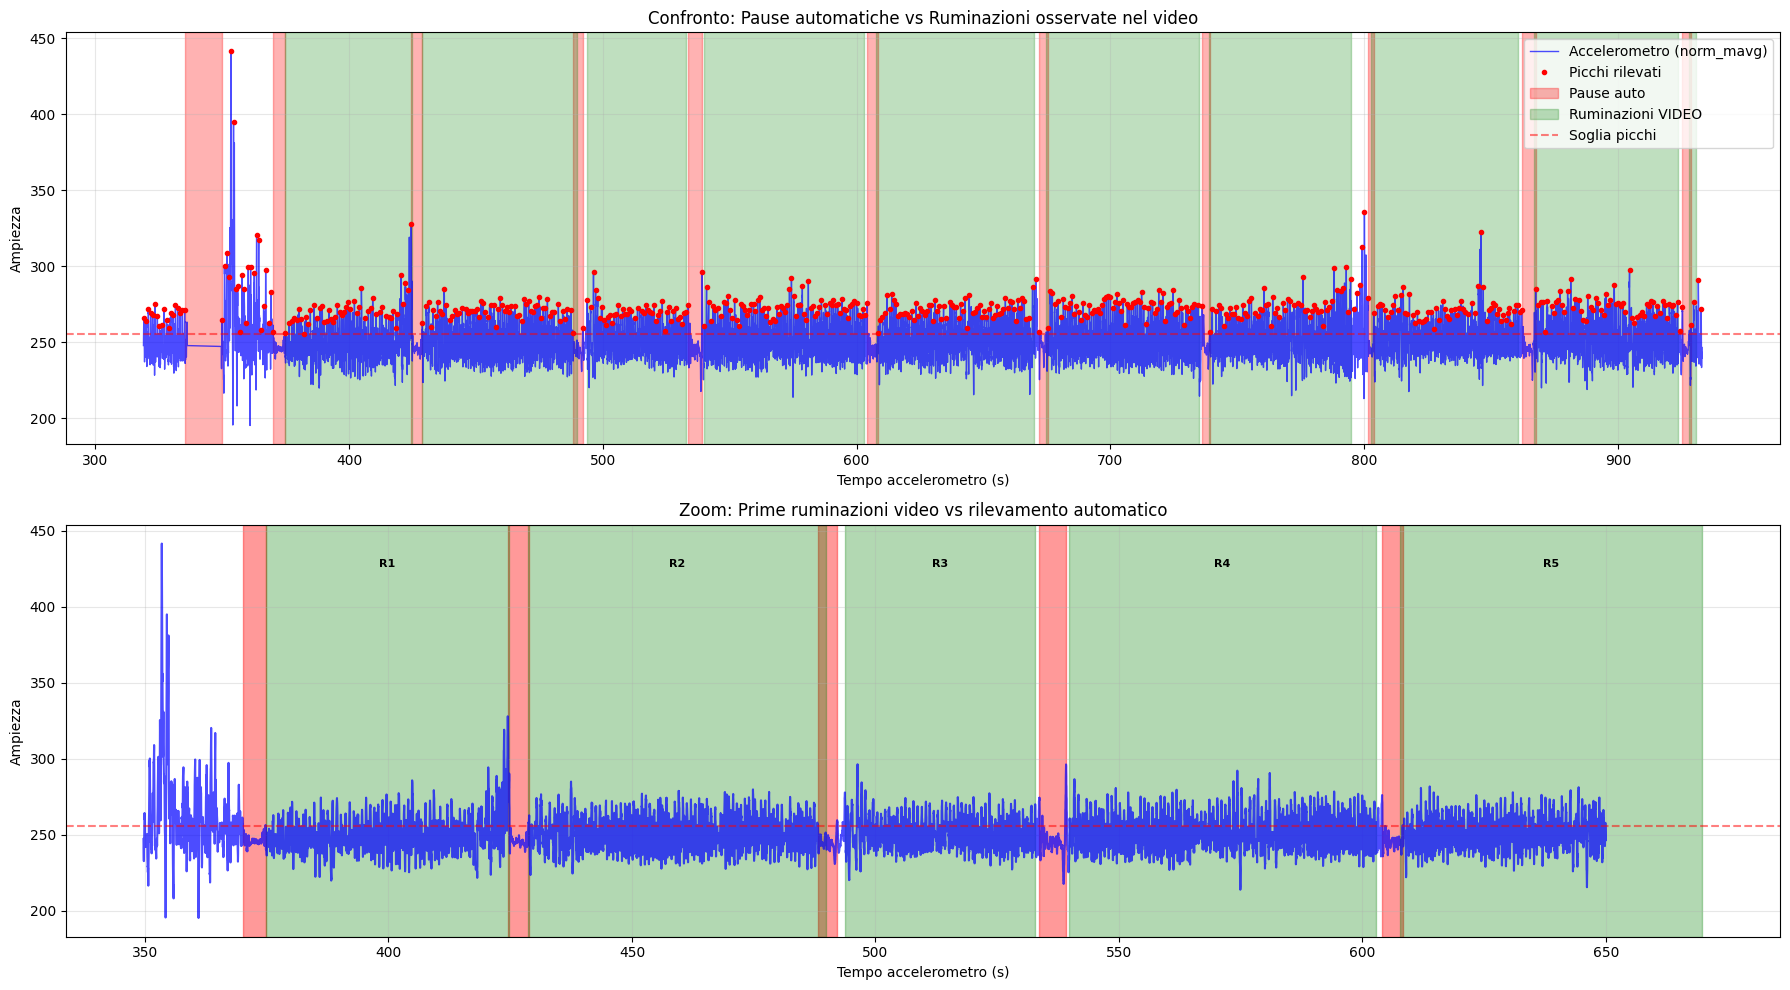


=== ANALISI CONFRONTO ===
Ruminazioni video: 10
Ruminazioni auto: 12

Sovrapposizioni trovate:
  Video R1 ↔ Auto R3: 100.0% (49.7s)
  Video R2 ↔ Auto R4: 100.0% (59.3s)
  Video R3 ↔ Auto R5: 100.0% (39.0s)
  Video R4 ↔ Auto R6: 100.0% (63.0s)
  Video R5 ↔ Auto R7: 99.2% (61.5s)
  Video R6 ↔ Auto R8: 99.1% (59.5s)
  Video R7 ↔ Auto R9: 99.4% (55.7s)
  Video R8 ↔ Auto R10: 98.3% (57.0s)
  Video R9 ↔ Auto R11: 98.6% (56.2s)
  Video R10 ↔ Auto R12: 65.9% (2.0s)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# === PARAMETRI SEMPLIFICATI ===
csv_path = r"C:\Users\eleut\OneDrive\Desktop\accelerometer_datalogvideo3_processed.csv"
pause_threshold = 2.0           # soglia pause ridotta a 2s
after_time = 319.0              # tempo inizio analisi
long_rumination_threshold = 60  # ruminazioni "sospette" > 60s
peak_density_threshold = 0.15   # densità picchi minima (picchi/secondo)

# === RIFERIMENTI DAL VIDEO ===
# Il video inizia 25 secondi prima di 374.75s dell'accelerometro
video_start_accel = 374.75 - 25  # = 349.75s nell'accelerometro

# Conversione tempi video (mm:ss) in secondi accelerometro
video_ruminations = [
    (25, 75),    # 0:25 - 1:15
    (79, 140),   # 1:19 - 2:20  
    (144, 183),  # 2:24 - 3:03
    (190, 253),  # 3:10 - 4:13
    (258, 320),  # 4:18 - 5:20
    (325, 385),  # 5:25 - 6:25
    (389, 445),  # 6:29 - 7:25
    (453, 511),  # 7:33 - 8:31
    (517, 574),  # 8:37 - 9:34
    (578, 581)   # 9:38 - 9:41
]

# Converte in tempi accelerometro
accel_ruminations = []
for start_vid, end_vid in video_ruminations:
    start_accel = video_start_accel + start_vid
    end_accel = video_start_accel + end_vid
    accel_ruminations.append((start_accel, end_accel, end_accel - start_accel))

print("=== RIFERIMENTI DAL VIDEO (convertiti in tempi accelerometro) ===")
for i, (start, end, dur) in enumerate(accel_ruminations, 1):
    print(f"Ruminazione {i}: {start:.1f}s - {end:.1f}s (durata: {dur:.1f}s)")

# === CARICA DATI ===
df = pd.read_csv(csv_path)
if 'time_s' not in df.columns:
    if 'time_ms' in df.columns:
        df['time_s'] = df['time_ms'] / 1000.0
    else:
        raise ValueError("Manca la colonna 'time_s' o 'time_ms' nel CSV")

def detect_pauses_simple(df, signal_col='norm_mavg'):
    """Versione semplificata per rilevare pause"""
    time = df['time_s'].values
    signal = df[signal_col].values
    
    # Filtra dopo after_time
    mask = time >= after_time
    time = time[mask]
    signal = signal[mask]
    
    # Parametri base
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    height_thr = mean_val + 0.3 * std_val
    
    # Trova picchi
    fs = 1.0 / np.median(np.diff(time))
    min_dist = int(0.5 * fs)
    peaks_idx, _ = find_peaks(signal, height=height_thr, distance=min_dist)
    peaks_time = time[peaks_idx]
    peaks_values = signal[peaks_idx]
    
    # Trova pause base (tra picchi)
    pauses = []
    prev_time = time[0]
    for pt in peaks_time:
        if pt - prev_time >= pause_threshold:
            pauses.append((prev_time, pt, pt - prev_time))
        prev_time = pt
    
    # Controlla ruminazioni lunghe per pause nascoste
    ruminations_temp = []
    if pauses:
        start = time[0]
        for p_start, p_end, _ in sorted(pauses):
            if p_start > start:
                ruminations_temp.append((start, p_start, p_start - start))
            start = p_end
        if start < time[-1]:
            ruminations_temp.append((start, time[-1], time[-1] - start))
    else:
        ruminations_temp.append((time[0], time[-1], time[-1] - time[0]))
    
    # Verifica ruminazioni lunghe
    additional_pauses = []
    for rum_start, rum_end, rum_dur in ruminations_temp:
        if rum_dur > long_rumination_threshold:
            # Conta picchi nell'intervallo
            mask_rum = (time >= rum_start) & (time <= rum_end)
            signal_rum = signal[mask_rum]
            peaks_rum, _ = find_peaks(signal_rum, height=mean_val, distance=min_dist)
            
            density = len(peaks_rum) / rum_dur
            if density < peak_density_threshold:
                additional_pauses.append((rum_start, rum_end, rum_dur))
                print(f"🔍 Pausa nascosta trovata: {rum_start:.1f}-{rum_end:.1f}s (densità: {density:.3f})")
    
    # Unisci tutte le pause
    all_pauses = sorted(pauses + additional_pauses)
    
    # Ricalcola ruminazioni finali
    ruminations = []
    if all_pauses:
        start = time[0]
        for p_start, p_end, _ in all_pauses:
            if p_start > start:
                ruminations.append((start, p_start, p_start - start))
            start = p_end
        if start < time[-1]:
            ruminations.append((start, time[-1], time[-1] - start))
    else:
        ruminations.append((time[0], time[-1], time[-1] - time[0]))
    
    return time, signal, peaks_time, peaks_values, all_pauses, ruminations, height_thr

# === ANALISI ===
time, signal, peaks_time, peaks_values, pauses, ruminations, height_thr = detect_pauses_simple(df)

print(f"\n=== RISULTATI ACCELEROMETRO ===")
print(f"Pause automatiche trovate ({len(pauses)}):")
for i, (start, end, dur) in enumerate(pauses, 1):
    print(f"  {i}. {start:.1f}s - {end:.1f}s (durata: {dur:.1f}s)")

print(f"\nRuminazioni automatiche trovate ({len(ruminations)}):")
for i, (start, end, dur) in enumerate(ruminations, 1):
    print(f"  {i}. {start:.1f}s - {end:.1f}s (durata: {dur:.1f}s)")

# === GRAFICI ===
plt.figure(figsize=(18, 10))

# Grafico principale
plt.subplot(2, 1, 1)
plt.plot(time, signal, 'b-', alpha=0.7, linewidth=1, label='Accelerometro (norm_mavg)')
plt.plot(peaks_time, peaks_values, 'ro', markersize=3, label='Picchi rilevati')

# Pause automatiche (rosso)
for i, (start, end, dur) in enumerate(pauses):
    plt.axvspan(start, end, color='red', alpha=0.3, 
               label='Pause auto' if i == 0 else '')

# Ruminazioni dal video (verde)
for i, (start, end, dur) in enumerate(accel_ruminations):
    plt.axvspan(start, end, color='green', alpha=0.25,
               label='Ruminazioni VIDEO' if i == 0 else '')

plt.axhline(y=height_thr, color='red', linestyle='--', alpha=0.5, label='Soglia picchi')
plt.xlabel('Tempo accelerometro (s)')
plt.ylabel('Ampiezza')
plt.title('Confronto: Pause automatiche vs Ruminazioni osservate nel video')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom sulla zona iniziale
plt.subplot(2, 1, 2)
mask_zoom = (time >= 340) & (time <= 650)
time_zoom = time[mask_zoom]
signal_zoom = signal[mask_zoom]

plt.plot(time_zoom, signal_zoom, 'b-', alpha=0.7, linewidth=1.5)

# Pause e ruminazioni nella zona zoom
for start, end, dur in pauses:
    if start >= 340 and start <= 650:
        plt.axvspan(start, end, color='red', alpha=0.4)

for i, (start, end, dur) in enumerate(accel_ruminations):
    if start >= 340 and start <= 650:
        plt.axvspan(start, end, color='green', alpha=0.3)
        # Aggiungi numero ruminazione
        plt.text(start + dur/2, plt.ylim()[1]*0.95, f'R{i+1}', 
                ha='center', va='top', fontsize=8, fontweight='bold')

plt.axhline(y=height_thr, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Tempo accelerometro (s)')
plt.ylabel('Ampiezza')
plt.title('Zoom: Prime ruminazioni video vs rilevamento automatico')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === ANALISI CONFRONTO ===
print(f"\n=== ANALISI CONFRONTO ===")
print(f"Ruminazioni video: {len(accel_ruminations)}")
print(f"Ruminazioni auto: {len(ruminations)}")

# Verifica sovrapposizioni
overlaps = []
for i, (rv_start, rv_end, rv_dur) in enumerate(accel_ruminations):
    for j, (ra_start, ra_end, ra_dur) in enumerate(ruminations):
        # Calcola sovrapposizione
        overlap_start = max(rv_start, ra_start)
        overlap_end = min(rv_end, ra_end)
        if overlap_start < overlap_end:
            overlap_dur = overlap_end - overlap_start
            overlap_perc = overlap_dur / min(rv_dur, ra_dur) * 100
            overlaps.append((i+1, j+1, overlap_perc, overlap_dur))

print(f"\nSovrapposizioni trovate:")
for vid_rum, auto_rum, perc, dur in overlaps:
    print(f"  Video R{vid_rum} ↔ Auto R{auto_rum}: {perc:.1f}% ({dur:.1f}s)")